In [17]:
from datascience import *
%matplotlib inline
path_data = '../../../assets/data/'
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=np.VisibleDeprecationWarning)

# Lecture 24 #

## Bootstrap 

In [18]:
sf = Table.read_table('san_francisco_2019.csv')
min_salary = 15 * 20 * 50
sf = sf.where('Salary', are.above(min_salary))

In [19]:
sf.num_rows

37103

/usr/local/anaconda3/envs/d8/lib/python3.8/site-packages/datascience/tables.py:5206: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(ticks, rotation='vertical')


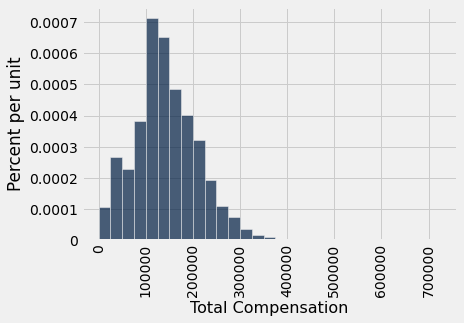

In [20]:
sf_bins = np.arange(0, 726000, 25000)
sf.hist('Total Compensation', bins=sf_bins)

In [21]:
# Parameter: Median total compensation in the population
def median_comp(t):
    return percentile(50, t.column('Total Compensation'))

median_comp(sf)

135747.0

## Bootstrap Estimates of the Parameter (Pretend it is Unknown) 

In [22]:
def confidence_interval_95(sample_size):
    # Collect one random sample from the population
    our_sample = sf.sample(sample_size, with_replacement=False)
    median_comp(our_sample)

    # Generate the medians of 1000 bootstrap samples
    num_repetitions = 1000
    bstrap_medians = make_array()
    for i in np.arange(num_repetitions):
        # Resample the same number of rows, with replacement
        bstrap_medians = np.append(bstrap_medians, 
                                   median_comp(our_sample.sample()))

    # Find the middle 95% of medians; that's a confidence interval
    left = percentile(2.5, bstrap_medians)
    right = percentile(97.5, bstrap_medians)
    return make_array(left, right)

confidence_interval_95(100)

array([124516., 147241.])

In [35]:
intervals = Table(['k', 'lower', 'upper', 'sample_size'])

for n in [2, 4, 8, 16]:
    for k in np.arange(intervals.num_rows, intervals.num_rows + 20):
        interval = confidence_interval_95(n)
        intervals = intervals.with_row([
            k, interval.item(0), interval.item(1), n
        ])
    
intervals.show(4)

k,lower,upper,sample_size
0,36250,139825,2
1,47519,147233,2
2,174321,248385,2
3,111217,219183,2


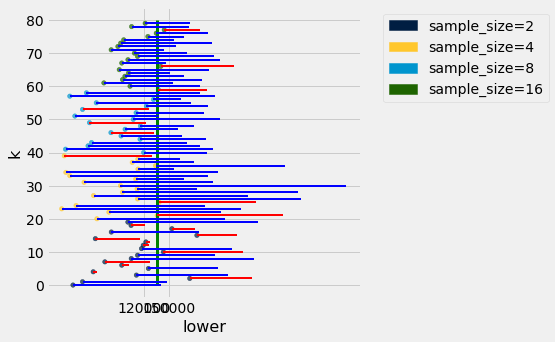

In [36]:
intervals.scatter('lower', 'k', group='sample_size')
truth = median_comp(sf)
plots.plot((truth, truth), (0, intervals.num_rows), color='green', lw=3)
plots.xticks([120000, 150000])
for row in intervals.rows:
    if row.item('lower') > truth or row.item('upper') < truth:
        color = 'red'
    else:
        color = 'blue'
    plots.plot((row.item('lower'), row.item('upper')),
               (row.item('k'), row.item('k')),
               color, lw=2)

## Confidence Interval for Unknown Population Mean

In [25]:
# Random sample of mother-newborn pairs
births = Table.read_table('baby.csv')

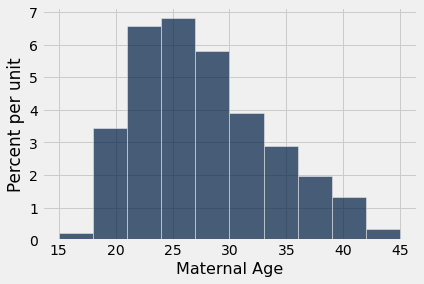

In [26]:
births.hist('Maternal Age')

In [27]:
# Average age of mothers in the sample
np.average(births.column('Maternal Age'))

27.228279386712096

### Question
What is the average age of the mothers in the population?

In [28]:
def one_bootstrap_mean():
    resample = births.sample()
    return np.average(resample.column('Maternal Age'))

In [29]:
# Generate means from 3000 bootstrap samples
num_repetitions = 3000
bstrap_means = make_array()
for i in np.arange(num_repetitions):
    bstrap_means = np.append(bstrap_means, one_bootstrap_mean())

### Bootstrap Percentile Method for Confidence Interval

The interval of estimates is the "middle 95%" of the bootstrap estimates.

This is called a *95% confidence interval* for the mean age in the population.

In [30]:
# Get the endpoints of the 95% confidence interval
left = percentile(2.5, bstrap_means)
right = percentile(97.5, bstrap_means)

make_array(left, right)

array([26.90459966, 27.55706985])

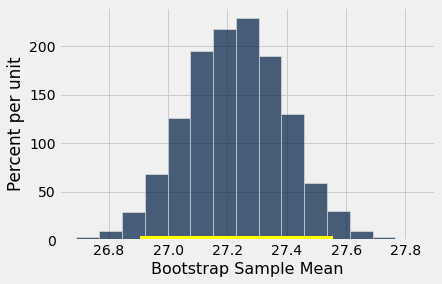

In [31]:
resampled_means = Table().with_columns(
    'Bootstrap Sample Mean', bstrap_means
)
resampled_means.hist(bins=15)
plots.plot([left, right], [0, 0], color='yellow', lw=8);

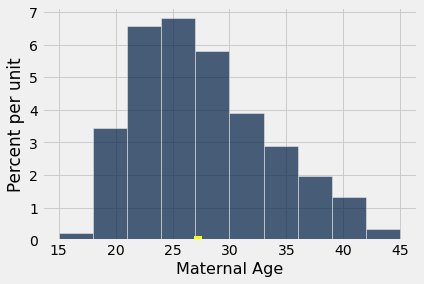

In [32]:
births.hist('Maternal Age')
plots.plot([left, right], [0, 0], color='yellow', lw=8);

## Using the Confidence Interval for Testing Hypotheses

**Null:** The average age of mothers in the population is 25 years; the random sample average is different due to chance.

**Alternative:** The average age of the mothers in the population is not 25 years.

Suppose you use the 5% cutoff for the p-value.

Based on the confidence interval, which hypothesis would you pick?